In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import math

from connect4.connect_state import ConnectState
from connect4.policy import Policy

from policy import SmartMCTS

from groups.GroupA.policy import Aha
from groups.GroupB.policy import Hello
from groups.GroupC.policy import OhYes
from groups.GroupG.policy import ClaimEvenPolicy
from groups.GroupF.policy import MinimaxPolicy
from groups.GroupE.policy import AllisPolicy



ModuleNotFoundError: No module named 'connect4'

In [13]:
def play_game(policy_red: Policy, policy_yellow: Policy, render=False):
    state = ConnectState()
    policies = {-1: policy_red, 1: policy_yellow}

    while not state.is_final():
        p = state.player
        action = policies[p].act(state.board)

        if not state.is_applicable(action):
            # Illegal move loses
            return -p
        
        state = state.transition(action)
        
        if render:
            print(state.board)
            print("---------------")

    return state.get_winner()


In [14]:
def evaluate(red_policy_class, yellow_policy_class, n_games=5, desc=None):
    results = { "red": 0, "yellow": 0, "draw": 0 }

    iterator = range(n_games)
    if desc is not None:
        iterator = tqdm(iterator, desc=desc, leave=False)

    for i in iterator:
        red = red_policy_class()
        yellow = yellow_policy_class()
        red.mount()
        yellow.mount()

        w = play_game(red, yellow)
        if w == -1:
            results["red"] += 1
        elif w == 1:
            results["yellow"] += 1
        else:
            results["draw"] += 1

    return results


In [16]:
from tqdm import tqdm
import pandas as pd

random_groups = {
    "OhYes": OhYes,
    "Hello": Hello,
    "Aha": Aha
}

results_smart_vs_random = {}

total_matchups = len(random_groups)
with tqdm(total=total_matchups, desc="SmartMCTS vs Random Groups") as pbar:
    for gname, gpol in random_groups.items():
        matchup_desc = f"SmartMCTS (Rojo) vs {gname} (Amarillo)"
        res = evaluate(SmartMCTS, gpol, n_games=20, desc=matchup_desc)
        results_smart_vs_random[gname] = res
        pbar.update(1)

df_smart_vs_random = pd.DataFrame(results_smart_vs_random).T
df_smart_vs_random


SmartMCTS vs Random Groups: 100%|██████████| 3/3 [03:48<00:00, 76.09s/it]


,red,yellow,draw
OhYes,20,0,0
Hello,20,0,0
Aha,20,0,0


In [ ]:
strong_rules = {
    "Claimeven": ClaimEvenPolicy,
    "Allis": AllisPolicy,
    "Minimax": MinimaxPolicy
}

results_rules_vs_random = {}

total_matchups = len(strong_rules) * len(random_groups)
with tqdm(total=total_matchups, desc="Rules/Minimax vs Random Groups") as pbar:
    for sname, spol in strong_rules.items():
        for gname, gpol in random_groups.items():
            matchup_desc = f"{sname} (Rojo) vs {gname} (Amarillo)"
            res = evaluate(spol, gpol, n_games=20, desc=matchup_desc)
            results_rules_vs_random[(sname, gname)] = res
            pbar.update(1)

df_rules_vs_random = (
    pd.DataFrame(results_rules_vs_random).T
      .rename_axis(["StrongPolicy","RandomGroup"])
)
df_rules_vs_random


Rules/Minimax vs Random Groups: 100%|██████████| 9/9 [17:37<00:00, 117.55s/it]


red  yellow  draw
StrongPolicy RandomGroup                   
Claimeven    OhYes         19       1     0
             Hello         20       0     0
             Aha           20       0     0
Allis        OhYes         20       0     0
             Hello         19       1     0
             Aha           20       0     0
Minimax      OhYes         20       0     0
             Hello         20       0     0
             Aha           20       0     0

In [ ]:
results_smart_vs_rules = {}

total_matchups = len(strong_rules)
with tqdm(total=total_matchups, desc="SmartMCTS vs Rules/Minimax") as pbar:
    for sname, spol in strong_rules.items():
        matchup_desc = f"SmartMCTS (Rojo) vs {sname} (Amarillo)"
        res = evaluate(SmartMCTS, spol, n_games=20, desc=matchup_desc)
        results_smart_vs_rules[sname] = res
        pbar.update(1)

df_smart_vs_rules = pd.DataFrame(results_smart_vs_rules).T
df_smart_vs_rules


SmartMCTS vs Rules/Minimax: 100%|██████████| 3/3 [15:16<00:00, 305.47s/it]


,red,yellow,draw
Claimeven,10,10,0
Allis,9,9,2
Minimax,0,20,0


In [ ]:
rows = []
for gname, res in results_smart_vs_random.items():
    rows.append({
        "Bloque": "Smart vs Random",
        "RedPolicy": "SmartMCTS",
        "YellowPolicy": gname,
        "RedWins": res["red"],
        "YellowWins": res["yellow"],
        "Draws": res["draw"]
    })

df1 = pd.DataFrame(rows)


# ---------- Bloque 2: (Claimeven/Allis/Minimax) vs Random Groups ----------
rows = []
for (sname, gname), res in results_rules_vs_random.items():
    rows.append({
        "Bloque": "Rules vs Random",
        "RedPolicy": sname,
        "YellowPolicy": gname,
        "RedWins": res["red"],
        "YellowWins": res["yellow"],
        "Draws": res["draw"]
    })

df2 = pd.DataFrame(rows)


# ---------- Bloque 3: SmartMCTS vs (Claimeven/Allis/Minimax) ----------
rows = []
for sname, res in results_smart_vs_rules.items():
    rows.append({
        "Bloque": "Smart vs Rules",
        "RedPolicy": "SmartMCTS",
        "YellowPolicy": sname,
        "RedWins": res["red"],
        "YellowWins": res["yellow"],
        "Draws": res["draw"]
    })

df3 = pd.DataFrame(rows)


# ---------- Concatenar todo ----------
df_all = pd.concat([df1, df2, df3], ignore_index=True)

# métricas extra
df_all["Total"] = df_all["RedWins"] + df_all["YellowWins"] + df_all["Draws"]
df_all["RedWinRate%"] = 100 * df_all["RedWins"] / df_all["Total"]
df_all["YellowWinRate%"] = 100 * df_all["YellowWins"] / df_all["Total"]
df_all["DrawRate%"] = 100 * df_all["Draws"] / df_all["Total"]

df_all


,Bloque,RedPolicy,YellowPolicy,RedWins,YellowWins,Draws,Total,RedWinRate%,YellowWinRate%,DrawRate%
0,Smart vs Random,SmartMCTS,OhYes,19,1,0,20,95.0,5.0,0.0
1,Smart vs Random,SmartMCTS,Hello,20,0,0,20,100.0,0.0,0.0
2,Smart vs Random,SmartMCTS,Aha,20,0,0,20,100.0,0.0,0.0
3,Rules vs Random,Claimeven,OhYes,19,1,0,20,95.0,5.0,0.0
4,Rules vs Random,Claimeven,Hello,20,0,0,20,100.0,0.0,0.0
5,Rules vs Random,Claimeven,Aha,20,0,0,20,100.0,0.0,0.0
6,Rules vs Random,Allis,OhYes,20,0,0,20,100.0,0.0,0.0
7,Rules vs Random,Allis,Hello,19,1,0,20,95.0,5.0,0.0
8,Rules vs Random,Allis,Aha,20,0,0,20,100.0,0.0,0.0
9,Rules vs Random,Minimax,OhYes,20,0,0,20,100.0,0.0,0.0


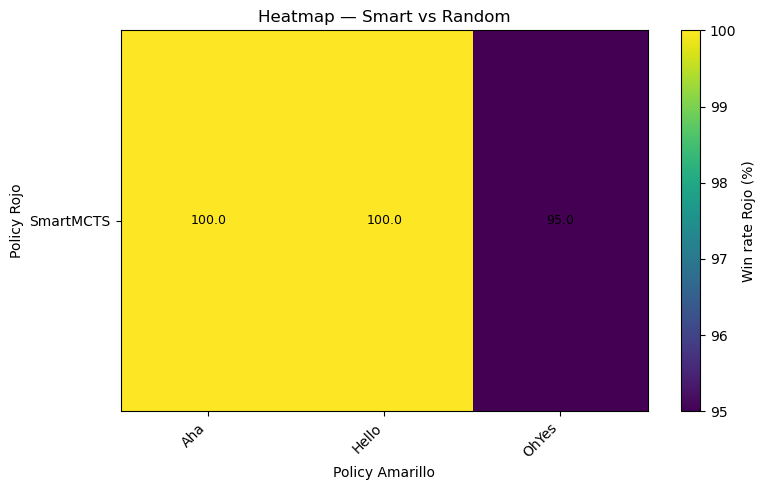

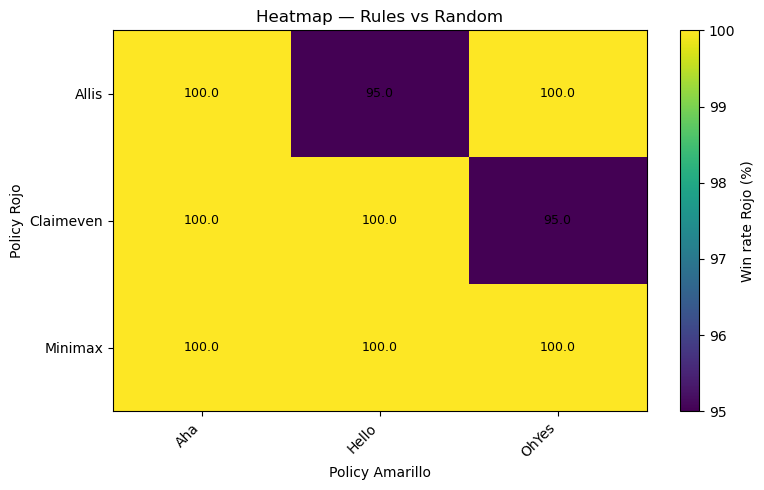

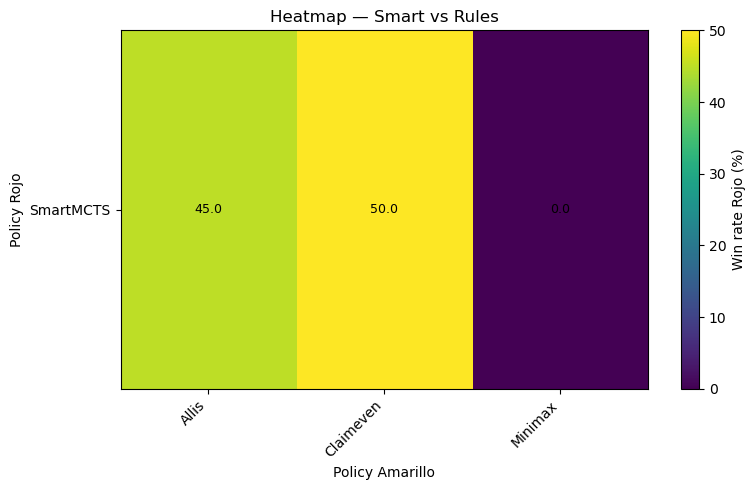

In [17]:
import numpy as np
import matplotlib.pyplot as plt

bloques = df_all["Bloque"].unique()

for bloque in bloques:
    df_b = df_all[df_all["Bloque"] == bloque]

    heatmap_b = df_b.pivot_table(
        index="RedPolicy",
        columns="YellowPolicy",
        values="RedWinRate%",
        aggfunc="mean"
    )

    plt.figure(figsize=(8,5))
    plt.imshow(heatmap_b.values, aspect="auto")
    plt.colorbar(label="Win rate Rojo (%)")

    plt.xticks(range(len(heatmap_b.columns)), heatmap_b.columns, rotation=45, ha="right")
    plt.yticks(range(len(heatmap_b.index)), heatmap_b.index)

    plt.title(f"Heatmap — {bloque}")
    plt.xlabel("Policy Amarillo")
    plt.ylabel("Policy Rojo")

    for i in range(heatmap_b.shape[0]):
        for j in range(heatmap_b.shape[1]):
            val = heatmap_b.values[i, j]
            if not np.isnan(val):
                plt.text(j, i, f"{val:.1f}", ha="center", va="center", fontsize=9)

    plt.tight_layout()
    plt.show()


In [ ]:
class MCTSNodeK:
    def __init__(self, state: np.ndarray, player: int, parent=None, action=None):
        self.state = state
        self.player = player  # jugador que ACABA de mover
        self.parent = parent
        self.action = action  # acción que llevó a este estado
        self.children = []
        self.visits = 0
        self.wins = 0  # desde la perspectiva del jugador raíz

    def is_fully_expanded(self, legal_moves: list[int]) -> bool:
        return len(self.children) == len(legal_moves)

    def best_child(self, c_param: float, k_factor: float) -> "MCTSNodeK":
        """
        UCT: (wins/visits) + c * sqrt( K * log(N) / n )
        donde K = k_factor (antes K=2 fijo).
        """
        choices_weights = []
        for child in self.children:
            exploit = child.wins / child.visits
            explore = math.sqrt(
                (k_factor * math.log(self.visits)) / child.visits
            )
            choices_weights.append(exploit + c_param * explore)

        return self.children[np.argmax(choices_weights)]

    def expand(self, action: int, new_state: np.ndarray, next_player: int) -> "MCTSNodeK":
        child = MCTSNodeK(new_state, next_player, self, action)
        self.children.append(child)
        return child


In [ ]:
class SmartMCTS_K(Policy):
    def __init__(self, iterations: int = 200, c_param: float = 1.414, k_factor: float = 2.0):
        self.iterations = iterations
        self.c_param = c_param
        self.k_factor = k_factor  # AQUÍ probaremos distintos valores de K

    def mount(self) -> None:
        pass

    def act(self, s: np.ndarray) -> int:
        root_player = self._get_current_player(s)
        legal_moves = self._get_legal_moves(s)
        if not legal_moves:
            raise ValueError("No legal moves available")

        root = MCTSNodeK(s, -root_player)

        for _ in range(self.iterations):
            node = root
            state = s.copy()

            # -------- Selection --------
            while node.children and not self._is_terminal(state):
                node = node.best_child(self.c_param, self.k_factor)
                state = self._simulate_move(state, node.action, -node.parent.player)

            # -------- Expansion --------
            current_legal = self._get_legal_moves(state)
            if current_legal and not self._is_terminal(state):
                action = random.choice(current_legal)
                new_state = self._simulate_move(state, action, -node.player)
                node = node.expand(action, new_state, -node.player)

            # -------- Simulation --------
            sim_state = node.state.copy()
            sim_player = -node.player
            while not self._is_terminal(sim_state):
                sim_actions = self._get_legal_moves(sim_state)
                if not sim_actions:
                    break
                sim_action = random.choice(sim_actions)
                sim_state = self._simulate_move(sim_state, sim_action, sim_player)
                sim_player = -sim_player

            # -------- Backpropagation --------
            winner = self._get_winner(sim_state)
            result = 1 if winner == root_player else -1 if winner == -root_player else 0

            current_node = node
            while current_node is not None:
                current_node.visits += 1
                if -current_node.player == root_player:
                    current_node.wins += result
                else:
                    current_node.wins += -result
                current_node = current_node.parent

        # -------- Choose best action --------
        if not root.children:
            return int(random.choice(legal_moves))
        best_child = max(root.children, key=lambda c: c.visits)
        return best_child.action

    # ======= Helpers (copiados de tu implementación) ======= #

    def _get_winner(self, board: np.ndarray) -> int:
        # Horizontal
        for r in range(6):
            for c in range(4):
                p = board[r, c]
                if p != 0 and np.all(board[r, c : c + 4] == p):
                    return p
        # Vertical
        for c in range(7):
            for r in range(3):
                p = board[r, c]
                if p != 0 and np.all(board[r : r + 4, c] == p):
                    return p
        # Positive diagonal
        for r in range(3):
            for c in range(4):
                p = board[r, c]
                if p != 0 and all(board[r + i, c + i] == p for i in range(4)):
                    return p
        # Negative diagonal
        for r in range(3):
            for c in range(3, 7):
                p = board[r, c]
                if p != 0 and all(board[r + i, c - i] == p for i in range(4)):
                    return p
        return 0

    def _is_terminal(self, board: np.ndarray) -> bool:
        return self._get_winner(board) != 0 or np.all(board[0] != 0)

    def _get_legal_moves(self, board: np.ndarray) -> list[int]:
        if self._get_winner(board) != 0:
            return []
        return [c for c in range(7) if board[0, c] == 0]

    def _simulate_move(self, board: np.ndarray, col: int, player: int) -> np.ndarray:
        new_board = board.copy()
        for r in range(5, -1, -1):
            if new_board[r, col] == 0:
                new_board[r, col] = player
                return new_board
        raise ValueError(f"Invalid column {col}")

    def _get_current_player(self, board: np.ndarray) -> int:
        num_red = np.count_nonzero(board == -1)
        num_yellow = np.count_nonzero(board == 1)
        return -1 if num_red == num_yellow else 1


In [ ]:
def play_single_game(group_policy, strong_policy, group_starts: bool):
    """
    group_policy y strong_policy son INSTANCIAS de Policy ya montadas.
    group_starts: True si el grupo juega como -1, False si el fuerte juega como -1.
    """
    if group_starts:
        policy_neg = group_policy
        policy_pos = strong_policy
    else:
        policy_neg = strong_policy
        policy_pos = group_policy

    state = ConnectState()
    n_moves = 0
    policies = {-1: policy_neg, 1: policy_pos}

    while not state.is_final():
        current_player = state.player
        current_policy = policies[current_player]

        action = current_policy.act(state.board)

        if not state.is_applicable(action):
            winner = -current_player
            return winner, n_moves

        state = state.transition(action)
        n_moves += 1

    winner = state.get_winner()
    return winner, n_moves


In [ ]:
from tqdm import tqdm

def eval_K_vs_group(group_policy_class, k_factor: float, n_games: int = 10, iterations: int = 50):
    results = {
        "group_wins": 0,
        "strong_wins": 0,
        "draws": 0,
    }

    # barra de progreso interna
    for i in tqdm(range(n_games), desc=f"K={k_factor}", leave=False):
        group = group_policy_class()
        strong = SmartMCTS_K(iterations=iterations, c_param=1.414, k_factor=k_factor)

        group.mount()
        strong.mount()

        group_starts = (i % 2 == 0)  # alternamos quién empieza

        winner, _ = play_single_game(group, strong, group_starts)

        # del punto de vista del SmartMCTS_K
        if group_starts:
            # grupo era -1
            if winner == -1:
                results["group_wins"] += 1
            elif winner == 1:
                results["strong_wins"] += 1
            else:
                results["draws"] += 1
        else:
            # MCTS era -1
            if winner == -1:
                results["strong_wins"] += 1
            elif winner == 1:
                results["group_wins"] += 1
            else:
                results["draws"] += 1

    return results


In [ ]:
K_values = [0.5, 1.0, 2.0, 4.0]
n_games = 15   

groups = {
    "Group A (Aha)": Aha,
    "Group B (Hello)": Hello,
    "Group C (OhYes)": OhYes,
}

results_all = {gname: {} for gname in groups.keys()}

from tqdm import tqdm

for gname, gclass in tqdm(groups.items(), desc="Evaluando grupos"):
    for K in tqdm(K_values, desc=f"Ks para {gname}", leave=False):
        res = eval_K_vs_group(gclass, k_factor=K, n_games=n_games, iterations=200)
        results_all[gname][K] = res

results_all


Evaluando grupos:   0%|          | 0/3 [00:00<?, ?it/s]

K=0.5:   0%|          | 0/15 [00:00<?, ?it/s]











Evaluando grupos:   0%|          | 0/3 [00:41<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
for gname in groups.keys():
    Ks = []
    wins = []
    losses = []
    draws = []

    for K in K_values:
        Ks.append(K)
        res = results_all[gname][K]
        wins.append(res["strong_wins"])
        losses.append(res["group_wins"])
        draws.append(res["draws"])

    plt.figure(figsize=(7,4))
    plt.plot(Ks, wins, marker="o", label="SmartMCTS_K wins")
    plt.plot(Ks, losses, marker="o", label="Group wins")
    plt.plot(Ks, draws, marker="o", label="Draws")
    plt.xlabel("K en término de exploración (K * log(N)/n)")
    plt.ylabel(f"Número de resultados en {n_games} partidas")
    plt.title(f"Resultados vs {gname} para distintos K")
    plt.legend()
    plt.grid(True)
    plt.show()


In [13]:
from policy_tester import verify_MCTS_learning
from groups.GroupA.policy import Aha
from groups.GroupF.policy import MinimaxPolicy
from groups.GroupE.policy import AllisPolicy


N_BATCHES = 10

N_GAMES = 30


In [ ]:
verify_MCTS_learning(n_games=N_GAMES,n_batches=N_BATCHES, rival_policy_class= Aha)

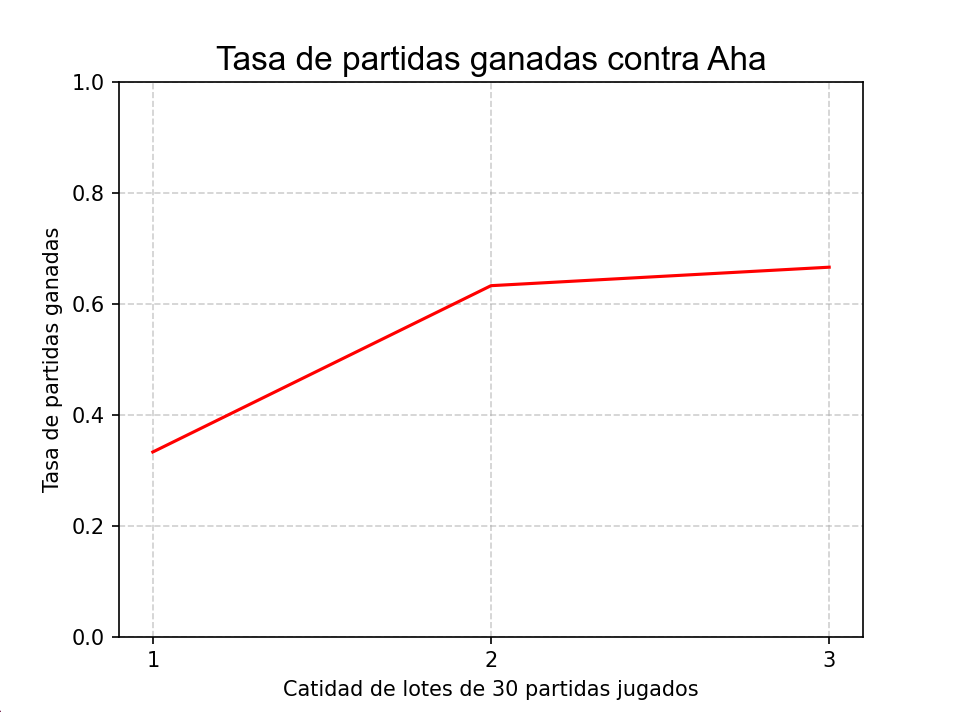

In [ ]:
verify_MCTS_learning(n_games=N_GAMES,n_batchs=N_BATCHES, rival_policy_class= MinimaxPolicy)


In [7]:
import pandas as pd

df = pd.read_parquet("q_values.parquet")
print("Rows:", len(df))
print(df.head())


Rows: 1669
                                               state  action         q  \
0  0000000000000000000000000000000000000000000000...       2  0.130819   
1  0000000000000000000000000000000000000000000000...       3  0.194663   
2  0000000000000000000000000000000000000000000000...       4  0.143199   
3  0000000000000000000000000000000000000000000000...       4  0.156801   
4  0000000000000000000000000000000000000000000000...       3  0.168352   

   sa_count  
0      65.0  
1     108.0  
2      37.0  
3      37.0  
4     117.0  


In [ ]:
import pandas as pd

df = pd.read_parquet("q_values.parquet")
print(df.iloc[1388:1393])

                                                  state  action         q  \
1388  00000000000000000000000000000000ffffffffffffff...       0 -0.744424   
1389  00000000000000000000000000000000ffffffffffffff...       6 -0.610753   
1390  00000000000000000000000000000000ffffffffffffff...       1  0.910753   
1391  00000000000000000000000000000000ffffffffffffff...       1 -0.360753   
1392  00000000000000000000000000000000ffffffffffffff...       1  0.910753   

      sa_count  
1388      21.0  
1389       1.0  
1390       1.0  
1391       1.0  
1392       1.0  
